# Hybrid Automatic Repeat Request (HARQ) in 5G with Sionna

This tutorial demonstrates how HARQ with redundancy versions (RVs) is used in 5G NR, and how to model it in Sionna. HARQ is a fundamental mechanism to improve reliability over unreliable wireless links, combining forward error correction and retransmission strategies.

## What is HARQ?

Hybrid Automatic Repeat Request (HARQ) is a mechanism used in wireless communications, particularly 5G, to enhance the reliability of data transmission over noisy and fading channels. It combines two techniques:

- **Forward Error Correction (FEC)**: Adds redundancy to transmitted data so that errors can be corrected at the receiver.
- **Automatic Repeat Request (ARQ)**: Requests retransmission of data if errors cannot be corrected.

In HARQ, when the initial transmission cannot be decoded, the receiver stores the soft information (LLRs) and combines it with new retransmissions. This is known as **soft combining**, and significantly improves decoding success probability.

## Redundancy Versions (RVs)

5G uses **Redundancy Versions (RVs)** to send different parts of the codeword in each retransmission. Instead of repeating the same bits, the encoder transmits different, complementary subsets selected via rate matching from a circular buffer. This increases decoding diversity and improves the effectiveness of soft combining.

**RV0** typically includes **most of the systematic bits and a portion of the parity bits**, providing the highest decoding reliability when transmitted first. Subsequent RVs (RV1–RV3) contain primarily parity bits, each selected from different sections of the buffer to maximize the value of retransmissions.

Common HARQ transmission orders include:

- `["rv0", "rv2"]`
- `["rv0", "rv2", "rv3", "rv1"]`
- Even `["rv0", "rv0"]` in case of severe interference during the first transmission

RVs are defined by their start positions within the rate-matching buffer and vary by specification (3GPP TS 38.212).

## Figure 1: HARQ Timeline with Retransmissions

The following figure shows a simplified HARQ process where retransmissions are triggered after decoding failures and new RVs are sent. Soft information is accumulated until decoding succeeds.



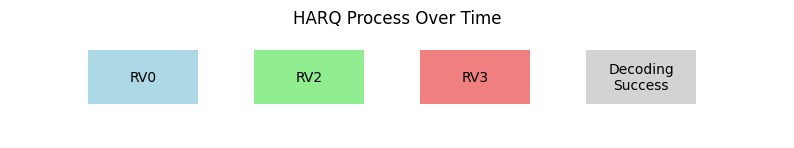

## Figure 2: Rate Matching and RV Selection in the Circular Buffer

This figure shows a conceptual view of the **circular buffer** used in 5G LDPC rate matching. The full encoded codeword is placed into the buffer, and each **redundancy version (RV)** selects a segment of bits starting from a specific offset.

- The **blue curve** (RV0) starts just after the top (12 o'clock) and includes most of the systematic bits and some parity — it's typically sent first and offers the highest decoding reliability.
- The **green curve** (RV1) begins from the right (3 o'clock) and covers a different section of the codeword.
- The **red curve** (RV2) starts from the bottom (6 o'clock) and consists mostly of parity bits.
- The **orange curve** (RV3) starts from the left (9 o'clock), spans parity bits, and wraps around to include part of the systematic region.

By transmitting different RVs in sequence, the system ensures that the decoder receives complementary redundancy, enhancing decoding performance via soft combining.

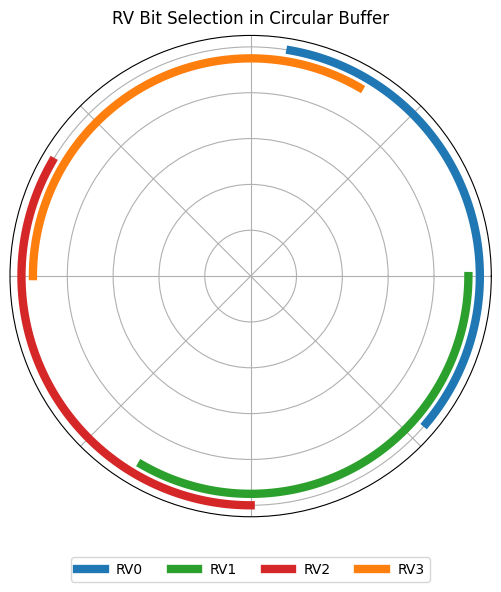

## Figure 3: LLR Soft Combining Across RVs

This plot shows how soft information from multiple RVs is combined. Each redundancy version covers a different portion of the codeword, and by combining them, the decoder not only reinforces existing information but also **fills in previously missing pieces**. This improves the reliability of bit decisions and enhances the overall **coding gain**. The final LLRs are the sum of individual RVs, resulting in stronger confidence for each bit position.

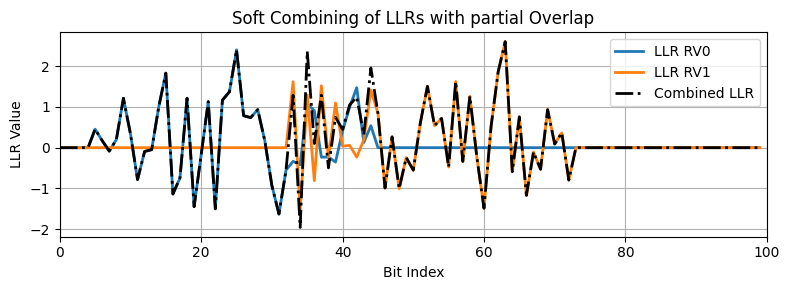

## HARQ Implementation in Sionna

Now that we've covered the concepts of HARQ and redundancy versions (RVs), we turn to how HARQ can be implemented and simulated in **Sionna**.

Sionna provides full access to the LDPC encoder and decoder, along with control over rate matching, channel transmission, and soft combining. This allows users to build HARQ pipelines that closely reflect real 5G behavior, including:

1. Encoding the LDPC codeword once.
2. Selecting multiple RVs using rate matching.
3. Transmitting each RV through the channel (sequentially or in parallel).
4. Reconstructing and combining LLRs, then decoding.

In the next cells, we'll walk through how this process can be implemented step by step.

## GPU Configuration and Imports

In [1]:
import os
import tensorflow as tf

# Configure GPU/CPU automatically
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("CUDA GPU detected - using GPU for computation")
    # Use first GPU and allow memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print("No CUDA GPU detected - using CPU for computation")
    tf.config.set_visible_devices([], 'GPU')
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e 

# For testing in eager mode, uncomment the following line:
# tf.config.run_functions_eagerly(True)

# Set random seed for reproducibility
sionna.phy.config.seed = 42

# Load the required Sionna components
from sionna.phy import Block
from sionna.phy.mapping import Constellation, Mapper, Demapper, BinarySource
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.utils import count_block_errors, ebnodb2no, PlotBER
from sionna.phy.channel import AWGN, FlatFadingChannel

2025-08-09 16:43:08.005071: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 16:43:08.008041: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-09 16:43:08.016414: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-09 16:43:08.047139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754750588.094966   51636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754750588.10

No CUDA GPU detected - using CPU for computation


2025-08-09 16:43:11.873060: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time # for throughput measurements

## BLER Performance of 5G LDPC HARQ in AWGN

For a codeword of length \( k = 64 \) and \( n = 150 \), we simulate five HARQ scenarios with an increasing number of retransmissions:

- **RV0 only** (no HARQ)
- **RV0 + RV0** (simple repetition)
- **RV0 + RV2**  (incremental redundancy)
- **RV0 + RV2 + RV3**  
- **RV0 + RV2 + RV3 + RV1**

Since the channel is **Additive White Gaussian Noise (AWGN)**, we assume that all RVs are transmitted over **independent and identically distributed (i.i.d.) channel realizations**. This enables **fully parallelized RV transmissions**, where all RVs are processed through the channel at once. This is a reasonable assumption when retransmissions are sufficiently spaced in time or frequency — such that the channel has decorrelated between RVs.

However, in some scenarios, RV transmissions may experience **correlated channels**. In that case, the RV stack can be **split and passed sequentially** through the channel, allowing the simulation to reflect evolving propagation characteristics across retransmissions.

Let us define the system model first. We use encoder and decoder as input parameter such that the model remains flexible w.r.t. the coding scheme.

In [3]:
class System_Model(Block):
    """System model for channel coding BER simulations.
    
    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to 
    initialize the model.
    
    Parameters
    ----------
        k: int
            number of information bits per codeword.
        
        n: int 
            codeword length.
        
        num_bits_per_symbol: int
            number of bits per QAM symbol.
            
        rv_set: list of str
            A list of redundancy versions (RV) to be used for the simulation.
            The RVs are used to set the FEC encoder and decoder to the correct
            redundancy version. Defaults to ['rv0'].
            
        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".
            
        sim_esno: bool  
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.

    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 rv_set=['rv0'],
                 demapping_method="app",
                 channel_model="awgn"):

        super().__init__()
        
        # store values internally
        self.k = k
        self.n = n
        
        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol

        # init components
        self.source = BinarySource()
       
        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)
        
        # the channel can be replaced by more sophisticated models
        self.channel_model = channel_model
        if self.channel_model == "awgn":
            self.channel = AWGN()
        elif self.channel_model == "flat_fading":
            self.channel = FlatFadingChannel(num_tx_ant=1, num_rx_ant=1)
        else:
            raise ValueError(f"Unsupported channel model: {self.channel_model}")

        # 5G LDPC codes with 20 BP iterations (prune_pcm not yet supported
        # in HARQ mode)
        self.encoder = LDPC5GEncoder(k=k, n=n)
        self.decoder = LDPC5GDecoder(self.encoder, num_iter=20,
                                     prune_pcm=False, harq_mode=True)

        # redundancy version set
        self.rv_set = rv_set

    @tf.function() # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        # calculate noise variance (values are Es/No)
        no = ebnodb2no(ebno_db, num_bits_per_symbol=1, coderate=1)

        u = self.source([batch_size, self.k]) # generate random data
        c = self.encoder(u, rv=self.rv_set) # explicitly encode
        x = self.mapper(c) # map c to symbols x
        y = self.channel(x, no) # transmit over AWGN channel
        llr_ch = self.demapper(y, no) # demap y to LLRs
        u_hat = self.decoder(llr_ch, rv=self.rv_set)  # decoder

        return u, u_hat

Run the BLER simulation for each scenario, with progressively more retransmissions. And plot the results.

EsNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -1.0 | 1.8811e-01 | 8.7550e-01 |      120392 |      640000 |         8755 |       10000 |         7.6 |reached target block errors
     -0.5 | 1.4770e-01 | 7.3170e-01 |       94528 |      640000 |         7317 |       10000 |         3.3 |reached target block errors
      0.0 | 1.0403e-01 | 5.3310e-01 |       66576 |      640000 |         5331 |       10000 |         2.9 |reached target block errors
      0.5 | 6.3744e-02 | 3.3570e-01 |       40796 |      640000 |         3357 |       10000 |         2.9 |reached target block errors
      1.0 | 3.3995e-02 | 1.8000e-01 |       21757 |      640000 |         1800 |       10000 |         2.8 |reached target block errors
      1.5 | 1.5475e-02 | 8.4300e-02 |        9904 |      640000 |

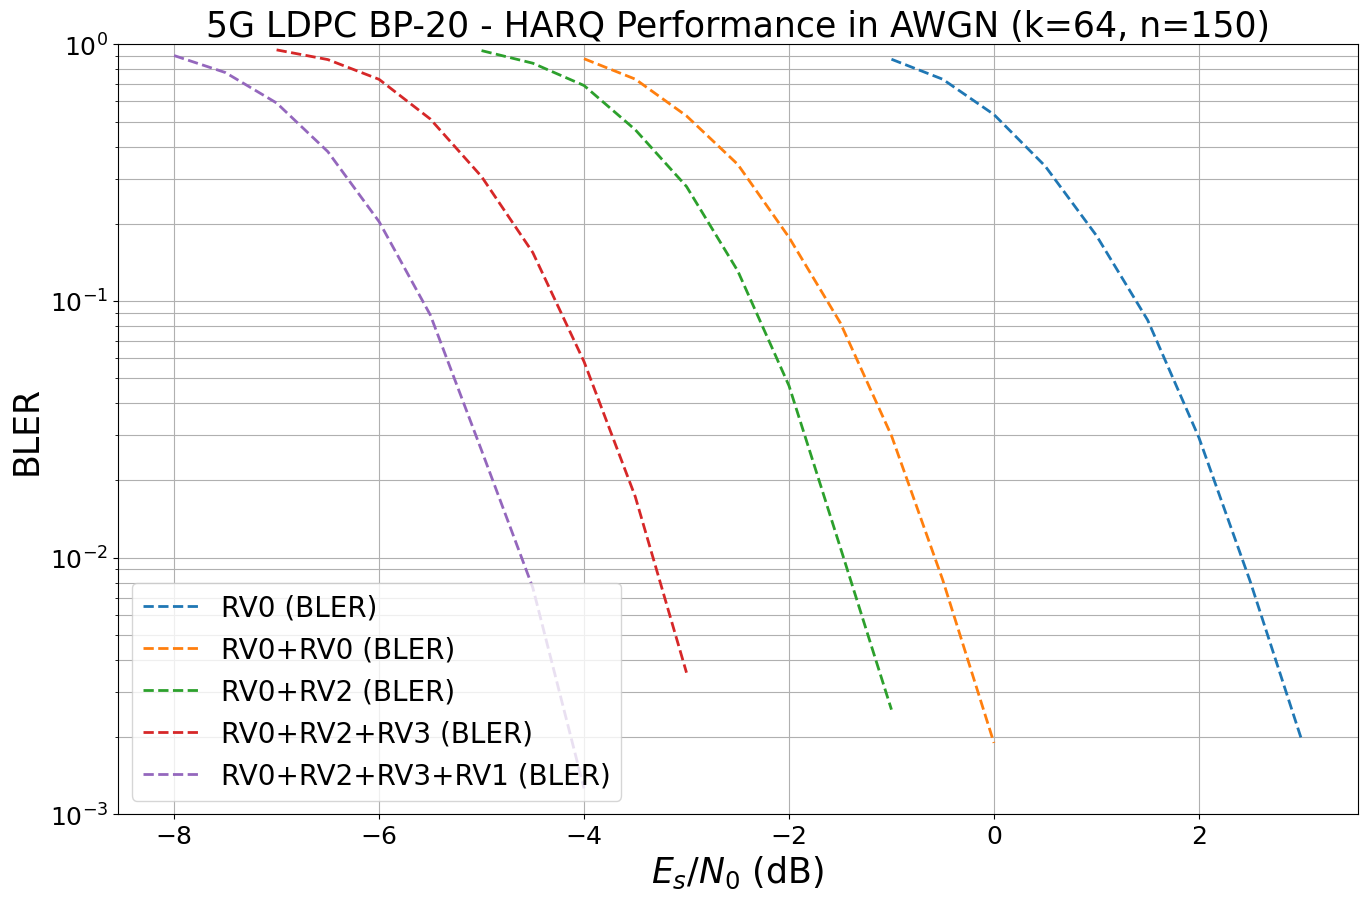

In [4]:
k = 64 # number of information bits per codeword
n = 150 # desired codeword length
# redundancy version set for HARQ
rv_set_set = [['rv0'], ['rv0', 'rv0'], ['rv0', 'rv2'], ['rv0', 'rv2', 'rv3'],
              ['rv0', 'rv2', 'rv3', 'rv1']]

num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(-1.0, 3.5, 0.5) # sim SNR range 
ebno_offset = np.array([0.0, -3.0, -4.0, -6.0, -7.0]) # offset for each number of retries

bler_plot128 = PlotBER(f"5G LDPC BP-20 - HARQ Performance in AWGN (k={k}, n={n})")

for i, rv_set in enumerate(rv_set_set):
    # run BLER simulations for each number of retransmission attempts:
    # rv0; rv0+rv2; rv0+rv2+rv3; rv0+rv2+rv3+rv1.
    # In each scenario, the first i+1 redundancy versions are used.
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         rv_set=rv_set)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    bler_plot128.simulate(model, # the function have defined previously
                          ebno_dbs=ebno_db + ebno_offset[i], # SNR to simulate
                          is_ebno=False, # we simulate Es/No
                          legend="+".join(rv.upper() for rv in rv_set),
                          max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                          num_target_block_errors=100, # continue with next SNR point after 1000 bit errors
                          batch_size=10000, # batch-size per Monte Carlo run
                          soft_estimates=False, # the model returns hard-estimates
                          early_stop=True, # stop simulation if no error has been detected at current SNR point
                          show_fig=False, # we show the figure after all results are simulated
                          add_bler=True, # in case BLER is also interesting
                          forward_keyboard_interrupt=True); # should be True in a loop

# and show the figure
bler_plot128(ylim=(1e-3, 1), is_ebno=False, show_ber=False, show_bler=True)

The result of the simulation is shown as five curves representing the **Block Error Rate (BLER)** as a function of **Es/No** for different HARQ scenarios. Each curve corresponds to a different number or combination of retransmissions:

- RV0 only (no HARQ)  
- RV0 + RV0 (simple repetition)  
- RV0 + RV2  
- RV0 + RV2 + RV3  
- RV0 + RV2 + RV3 + RV1  

In AWGN, we observe that repeating RV0 provides a gain of approximately **3 dB**, while switching to RV2 yields a slightly better gain of around **4 dB**, thanks to incremental redundancy. The difference is relatively modest in this scenario, but it can become significant when the initial coding rate is high.

In contrast, in non-AWGN channels with fading or sudden interference, the relative benefit of RV2 over repeating RV0 can vary. For example, if key bits (such as systematic bits) in RV0 were severely corrupted, retransmitting RV0 may be more beneficial than introducing new parity bits. This highlights that the **optimal retransmission strategy depends on channel conditions, coding rate, and RV structure** — and may not always favor incremental redundancy.